## Ćwiczenie 5 - Wykorzystanie sieci wielowarstwowej do klasyfikacji obrazów 
Maciej Dutkowski 260396

### Import i analizana danych

In [163]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms

In [299]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

data = torchvision.datasets.FashionMNIST('./test', download = True, transform=transform)
data_loader = torch.utils.data.DataLoader(data,
 batch_size=8,
 shuffle=True)

Dane zostają pobrane z datasetu torchvision FashionMNIST i zapisane w pamięci. 

In [165]:
print("Data set size:", len(data))

Data set size: 60000


Próbek jest 60 000.

In [166]:
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Klas 10 i każda z nich reprezentuje jeden typ ubrań.

In [167]:
dataiter = iter(data_loader)
images, labels = next(dataiter)

print("Label : ", labels[0], classes[labels[0]])
print("Image size : ", images.size())
print("Image row : ", images[0][0][14])

Label :  tensor(6) Shirt
Image size :  torch.Size([8, 1, 28, 28])
Image row :  tensor([-1.0000, -1.0000, -1.0000, -1.0000, -0.2706, -0.2941,  0.3647,  0.1294,
        -0.2941, -0.4510, -0.5137, -0.5294, -0.4510, -0.3961, -0.2314, -0.4980,
        -0.5373, -0.5294, -0.6392, -0.2157,  0.2235, -0.4588, -0.4745, -0.3725,
        -1.0000, -1.0000, -1.0000, -1.0000])


Jak widać każda z próbek jest czarnobiałym obrazkiem o rozmiarach 28x28. Wartość każdego z pikseli jest zakresu od 0 do 1 i oznacza jego jasność. Na potrzeby nauki sieci neuronowej zostały znormalizowane do wartości od -1 do 1, gdyż takie wartości są efektywniejsze do treningu. Etykieta jest liczbą całkowitą, która reprezentuje jedną z 10 klas.

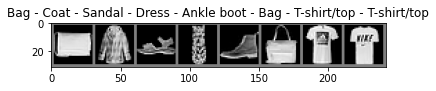

In [168]:
def imshow(img, labels):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(" - ".join([classes[labels[j]] for j in range(labels.size(0))]))
    plt.show()

dataiter = iter(data_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images), labels)

Zdjęcia ładowane są po określonym rozmiarze batcha (w tym przypadku 8). Jak widać są czarno białe i małej rozdzielczości, ale zazwyczaj proste do klasyfikacji dla człowieka.

### Przygotowanie danych i konfiguracja sieci

In [303]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset

In [179]:
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=False)

print("Training set size :", len(trainset))
print("Test set size :", len(testset))

Training set size : 60000
Test set size : 10000


Na początku dane zostały podzielone na zbiór do trenowania i testowania. Jak widać zbiór treningowy ma 60000 próbek a testowy 10000.

In [235]:
def getModelAccuracy(net, dataloader):    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

Została zdefiniowana funkcja licząca dokładność modelu.

In [361]:
def train_net(net, trainloader, optimizer, epochs_number=1, testloader=testloader):
    loss_values = []   
    for epoch in range(epochs_number):
        running_loss = 0.0 
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            
            outputs = net(inputs)
            loss = nn.CrossEntropyLoss()(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 100 == 99:
                avg_loss = running_loss / 100
                loss_values.append(avg_loss)
                running_loss = 0.0
        print("[ Epoch ", epoch+1, '/', epochs_number,  ']')
    print('Finished Training')
    net.eval()
    print('Accuracy for test set:', getModelAccuracy(net, dataloader=testloader), '%')
    print('Accuracy for training set:', getModelAccuracy(net, dataloader=trainloader), '%')

    plt.plot(loss_values, label='Training Loss')
    plt.title('Training Loss Over Time')
    plt.xlabel('Iterations')
    plt.ylabel('Average Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

Następnie funkcja przeprowadzająca proces uczenia modelu dla danej sieci, optymalizatora, liczby epok oraz zbiorów treningowych i testowych. Jako funkcję kosztu wykorzystuje entropię krzyżową. Wylicza i wyświetla ona dokładność modelu dla zbioru testowego i treningowego oraz rysuje wykres aktualnej uśrednionej wartości błędu dla kolejnych próbek.

### Wyniki

#### W zależności od liczby neuronów w warstwie ukrytej

##### Sieć jednowarstwowa 32 neurony

Została zaimplementowana podstawowa architektura sieci z jedną wartswą ukrytą. Wykorzystuje ona liniowe transformacje. Jej pierwszym krokiem jest spłaszczenie macierzy zdjęcia o wymiarze 28x28 na wektor o długości 784. Jako funkcję aktywacji na warstwach ukrytych korzysta z funkcji ReLU natomist na warstwie ukrytej z funkcji SoftMax, która zaimplementowana jest domyślnie w funkcji kosztu entropii krzyżowej. Pierwsza warstwa dla każdej z sieci ma 784, a wartwa wyjściowa zawsze ma 10 neuronów (gdyż klasyfikujemy do jednej z 10 klas).

Następnie zostały zdefiniowane 6 sieci o różnej ilości warstw ukrytych i różnej ilości neuronów na wartwach ukrytych. Dla kazdej z nich zostały przeprowadzone testy.

In [281]:
class BasicNet_1_32(nn.Module):
    def __init__(self):
        super(BasicNet_1_32, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

[ Epoch  1 / 3 ]
[ Epoch  2 / 3 ]
[ Epoch  3 / 3 ]
Finished Training
Accuracy for test set: 83.78 %
Accuracy for training set: 85.325 %


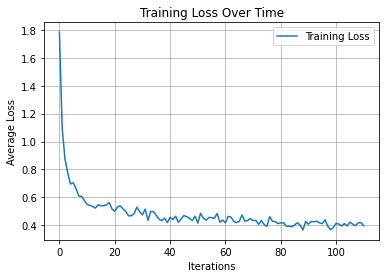

In [282]:
net = BasicNet_1_32()
optimizer = optim.SGD(net.parameters(), lr=0.01)
train_net(net=net, trainloader=trainloader, optimizer=optimizer, epochs_number=3)

##### Sieć jednowarstwowa 128 neuronów

In [283]:
class BasicNet_1_128(nn.Module):
    def __init__(self):
        super(BasicNet_1_128, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

[ Epoch  1 / 3 ]
[ Epoch  2 / 3 ]
[ Epoch  3 / 3 ]
Finished Training
Accuracy for test set: 84.96 %
Accuracy for training set: 86.66666666666667 %


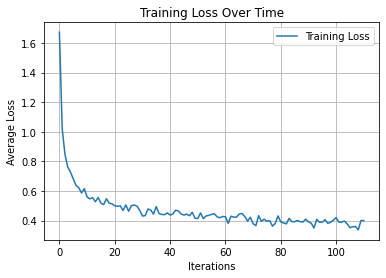

In [284]:
net = BasicNet_1_128()
optimizer = optim.SGD(net.parameters(), lr=0.01)
train_net(net=net, trainloader=trainloader, optimizer=optimizer, epochs_number=3)

##### Sieć jednowarstwowa 5000 neuronów

In [285]:
class BasicNet_1_5000(nn.Module):
    def __init__(self):
        super(BasicNet_1_5000, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 5000)
        self.fc2 = nn.Linear(5000, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

[ Epoch  1 / 3 ]
[ Epoch  2 / 3 ]
[ Epoch  3 / 3 ]
Finished Training
Accuracy for test set: 86.38 %
Accuracy for training set: 88.645 %


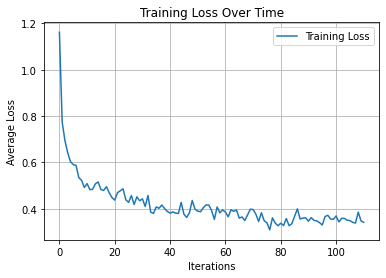

In [286]:
net = BasicNet_1_5000()
optimizer = optim.SGD(net.parameters(), lr=0.01)
train_net(net=net, trainloader=trainloader, optimizer=optimizer, epochs_number=3)

##### Sieć dwuwarstwowa 32 neurony

In [287]:
class BasicNet_2_32(nn.Module):
    def __init__(self):
        super(BasicNet_2_32, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

[ Epoch  1 / 3 ]
[ Epoch  2 / 3 ]
[ Epoch  3 / 3 ]
Finished Training
Accuracy for test set: 84.69 %
Accuracy for training set: 86.22333333333333 %


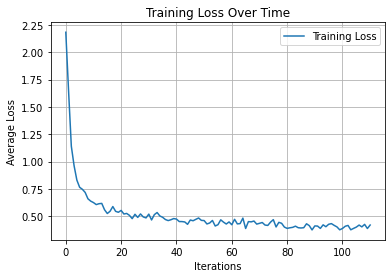

In [288]:
net = BasicNet_2_32()
optimizer = optim.SGD(net.parameters(), lr=0.01)
train_net(net=net, trainloader=trainloader, optimizer=optimizer, epochs_number=3)

##### Sieć dwuwarstwowa 64 neurony

In [289]:
class BasicNet_2_64(nn.Module):
    def __init__(self):
        super(BasicNet_2_64, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

[ Epoch  1 / 3 ]
[ Epoch  2 / 3 ]
[ Epoch  3 / 3 ]
Finished Training
Accuracy for test set: 84.59 %
Accuracy for training set: 86.29666666666667 %


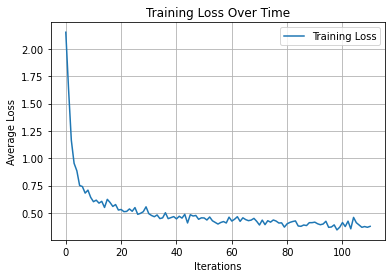

In [290]:
net = BasicNet_2_64()
optimizer = optim.SGD(net.parameters(), lr=0.01)
train_net(net=net, trainloader=trainloader, optimizer=optimizer, epochs_number=3)

##### Sieć dwuwarstwowa 256 neuronów

In [297]:
class BasicNet_2_256(nn.Module):
    def __init__(self):
        super(BasicNet_2_256, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

[ Epoch  1 / 3 ]
[ Epoch  2 / 3 ]
[ Epoch  3 / 3 ]
Finished Training
Accuracy for test set: 85.68 %
Accuracy for training set: 87.34 %


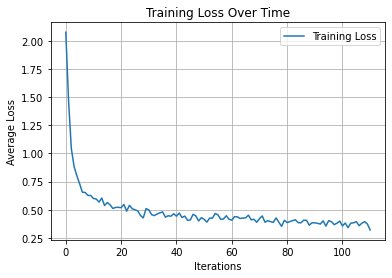

In [298]:
net = BasicNet_2_256()
optimizer = optim.SGD(net.parameters(), lr=0.01)
train_net(net=net, trainloader=trainloader, optimizer=optimizer, epochs_number=3)

Dla ustalonego współczynnika uczenia (0.01) i liczby epok (3) widoczny jest trend im większa sieć tym większa dokładność modelu. Najlepszy wynik (86%) został uzyskany dla sieci jednowarstwowej o ilości nueronów równej 5000. Możliwe, że aby uzykać lepsze wyniki dla sieci dwuwarstwowych należałoby uczyć przez większą liczbę epok, albo zmodyfikować wartość współczynnika uczenia, gdyż sieci wielowarstwowe zazwyczaj uczą się wolniej niż jednowarstwowe. W przeprowadzonych badaniach nie wystąpił efekt przeuczenia.

#### Wyniki w zależności od rozmiaru batcha

Następnie dla sieci jednowartwowej zostały przeprowadzone testy wpływu rozmiara batcha na zachowanie sieci.

##### Batch = 4

[ Epoch  1 / 3 ]
[ Epoch  2 / 3 ]
[ Epoch  3 / 3 ]
Finished Training
Accuracy for test set: 85.91 %
Accuracy for training set: 88.19 %


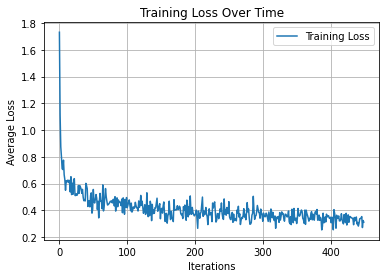

In [300]:
trainloader_batch_4 = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)
net = BasicNet_1_128()
optimizer = optim.SGD(net.parameters(), lr=0.01)
train_net(net=net, trainloader=trainloader_batch_4, optimizer=optimizer, epochs_number=3)

##### Batch = 32

[ Epoch  1 / 3 ]
[ Epoch  2 / 3 ]
[ Epoch  3 / 3 ]
Finished Training
Accuracy for test set: 83.91 %
Accuracy for training set: 85.255 %


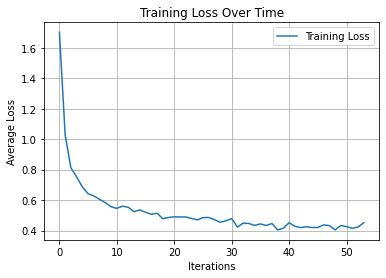

In [301]:
trainloader_batch_32 = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
net = BasicNet_1_128()
optimizer = optim.SGD(net.parameters(), lr=0.01)
train_net(net=net, trainloader=trainloader_batch_32, optimizer=optimizer, epochs_number=3)

##### Batch = 256

[ Epoch  1 / 3 ]
[ Epoch  2 / 3 ]
[ Epoch  3 / 3 ]
Finished Training
Accuracy for test set: 77.8 %
Accuracy for training set: 79.07833333333333 %


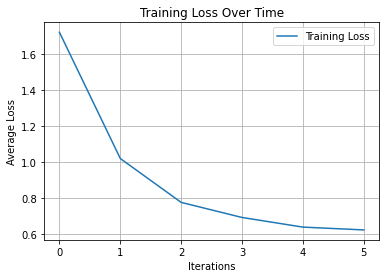

In [302]:
trainloader_batch_256 = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True)
net = BasicNet_1_128()
optimizer = optim.SGD(net.parameters(), lr=0.01)
train_net(net=net, trainloader=trainloader_batch_256, optimizer=optimizer, epochs_number=3)

Jak widać dla mniejszych batchy otrzymawana jest większa dokładność, jednak jest to kosztem czasu uczenia, który jest dużo krótszy dla większych rozmiarów batcha. W przypadku małych batchy występuje również większe ryzyko na utknięcie w minimum lokalnym, jednak tego nie widać w eksperymencie.

#### W zależności od liczby przykładów zbioru uczącego

##### 10% zbioru treningowego

Training set size : 6000
[ Epoch  1 / 10 ]
[ Epoch  2 / 10 ]
[ Epoch  3 / 10 ]
[ Epoch  4 / 10 ]
[ Epoch  5 / 10 ]
[ Epoch  6 / 10 ]
[ Epoch  7 / 10 ]
[ Epoch  8 / 10 ]
[ Epoch  9 / 10 ]
[ Epoch  10 / 10 ]
Finished Training
Accuracy for test set: 82.26 %
Accuracy for training set: 85.48333333333333 %


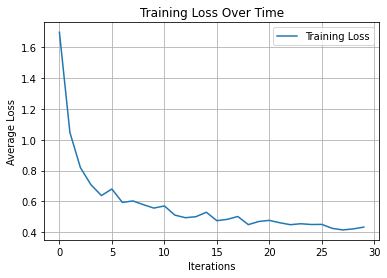

In [308]:
subset_size = int(0.1 * len(trainset))
subset_indices = torch.randperm(len(trainset))[:subset_size]

trainset_subset_01 = Subset(trainset, subset_indices)
trainloader_subset_01 = DataLoader(trainset_subset_01, batch_size=16, shuffle=True)
print("Training set size :", len(trainset_subset_01))

net = BasicNet_1_128()
optimizer = optim.SGD(net.parameters(), lr=0.01)
train_net(net=net, trainloader=trainloader_subset_01, optimizer=optimizer, epochs_number=10)

##### 1% zbioru treningowego

Training set size : 600
[ Epoch  1 / 100 ]
[ Epoch  2 / 100 ]
[ Epoch  3 / 100 ]
[ Epoch  4 / 100 ]
[ Epoch  5 / 100 ]
[ Epoch  6 / 100 ]
[ Epoch  7 / 100 ]
[ Epoch  8 / 100 ]
[ Epoch  9 / 100 ]
[ Epoch  10 / 100 ]
[ Epoch  11 / 100 ]
[ Epoch  12 / 100 ]
[ Epoch  13 / 100 ]
[ Epoch  14 / 100 ]
[ Epoch  15 / 100 ]
[ Epoch  16 / 100 ]
[ Epoch  17 / 100 ]
[ Epoch  18 / 100 ]
[ Epoch  19 / 100 ]
[ Epoch  20 / 100 ]
[ Epoch  21 / 100 ]
[ Epoch  22 / 100 ]
[ Epoch  23 / 100 ]
[ Epoch  24 / 100 ]
[ Epoch  25 / 100 ]
[ Epoch  26 / 100 ]
[ Epoch  27 / 100 ]
[ Epoch  28 / 100 ]
[ Epoch  29 / 100 ]
[ Epoch  30 / 100 ]
[ Epoch  31 / 100 ]
[ Epoch  32 / 100 ]
[ Epoch  33 / 100 ]
[ Epoch  34 / 100 ]
[ Epoch  35 / 100 ]
[ Epoch  36 / 100 ]
[ Epoch  37 / 100 ]
[ Epoch  38 / 100 ]
[ Epoch  39 / 100 ]
[ Epoch  40 / 100 ]
[ Epoch  41 / 100 ]
[ Epoch  42 / 100 ]
[ Epoch  43 / 100 ]
[ Epoch  44 / 100 ]
[ Epoch  45 / 100 ]
[ Epoch  46 / 100 ]
[ Epoch  47 / 100 ]
[ Epoch  48 / 100 ]
[ Epoch  49 / 100 ]
[ Epo

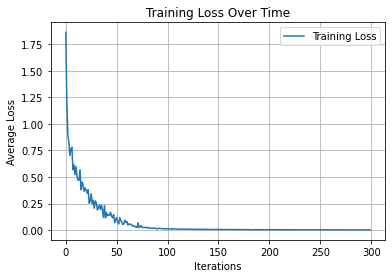

In [311]:
subset_size = int(0.01 * len(trainset))
subset_indices = torch.randperm(len(trainset))[:subset_size]

trainset_subset_001 = Subset(trainset, subset_indices)
trainloader_subset_001 = DataLoader(trainset_subset_001, batch_size=2, shuffle=True)
print("Training set size :", len(trainset_subset_001))

net = BasicNet_1_128()
optimizer = optim.SGD(net.parameters(), lr=0.01)
train_net(net=net, trainloader=trainloader_subset_001, optimizer=optimizer, epochs_number=100)

Według przewidywań im mniejszy jest rozmiar zbioru treningowego tym mniej dokładny jest ostatecznie model. Z racji na to, że zmniejszona liczba danych treningowych pozwala na szybsze uczenie, została zwiększna liczba epok. Dla 10% dało to satysfakcjonujące wyniki jednak mniejsze niż dla 100% zbioru treningowego. Przy zbiorze 1% wystąpił już ewidentny efekt przeuczenia, który doporowadził do słabej dokładności modelu.

#### W zależności od zaburzenia danch

Następnie obrazy zostały zaburzone szumem gaussowskim. W teorii może to pozwolić na lepszą generalizację modelu i ograniczenie efektu przeuczenia, jednak może również utrudnić (a nawet uniemożliwić) i wydłużyć naukę.

In [312]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.mean = mean
        self.std = std
    
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [374]:
transform_gaussian = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    AddGaussianNoise(0., 0.2)
])
trainset_gaussian = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_gaussian)
testset_gaussian = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform_gaussian)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


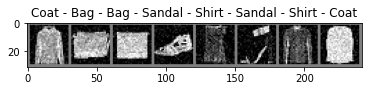

In [375]:
data_loader_gaussian_test = torch.utils.data.DataLoader(trainset_gaussian,
 batch_size=8,
 shuffle=True)

dataiter = iter(data_loader_gaussian_test)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images), labels)

Jak widać na zdjęciach występują teraz różne losowe artefakty.

[ Epoch  1 / 3 ]
[ Epoch  2 / 3 ]
[ Epoch  3 / 3 ]
Finished Training
Accuracy for test set: 84.82 %
Accuracy for training set: 87.10666666666667 %


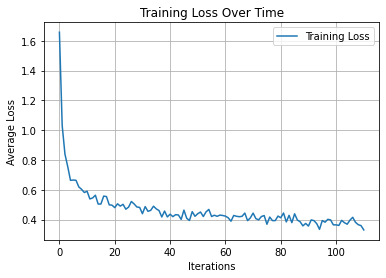

In [379]:
testloader_gaussian = torch.utils.data.DataLoader(testset_gaussian,
 batch_size=16,
 shuffle=False)

net = BasicNet_1_128()
optimizer = optim.SGD(net.parameters(), lr=0.01)
train_net(net=net, trainloader=trainloader, optimizer=optimizer, epochs_number=3, testloader=testloader_gaussian)

[ Epoch  1 / 4 ]
[ Epoch  2 / 4 ]
[ Epoch  3 / 4 ]
[ Epoch  4 / 4 ]
Finished Training
Accuracy for test set: 83.39 %
Accuracy for training set: 87.30333333333333 %


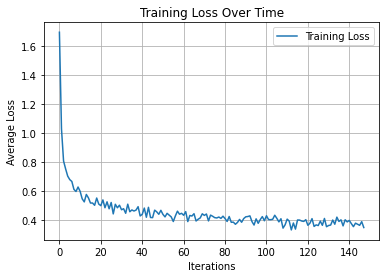

In [378]:
trainloader_gaussian = torch.utils.data.DataLoader(trainset_gaussian,
 batch_size=16,
 shuffle=True)

net = BasicNet_1_128()
optimizer = optim.SGD(net.parameters(), lr=0.01)
train_net(net=net, trainloader=trainloader_gaussian, optimizer=optimizer, epochs_number=4, testloader=testloader_gaussian)